In [ ]:
#pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner
#pip install scikeras

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)

In [2]:
# Read data
df = pd.read_csv('dataset_phishing.csv')

In [3]:
features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags', 'nb_hyphens', 'page_rank', 'avg_word_path', 'ratio_extHyperlinks',
 'longest_words_raw', 'google_index', 'length_hostname', 'longest_word_host', 'domain_registration_length', 'nb_www', 'nb_underscore', 'nb_dots',
 'ratio_extMedia', 'phish_hints', 'domain_in_title', 'web_traffic', 'safe_anchor', 'nb_space', 'shortening_service', 'ip', 'domain_age', 'nb_qm',
 'nb_hyperlinks', 'nb_slash']

In [4]:
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df["status"])

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# MLP
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(max_iter=2000, random_state=42, validation_fraction=0.15)

# Set up hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(200, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.008]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
mlp_best_model = grid_search.best_estimator_

# Evaluate the model on the validation set
mlp_y_pred = mlp_best_model.predict(X_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [6]:
#CNN

import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For performance metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix)

# For building the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, 
                                   BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a seed value for reproducibility
seed = 42

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [7]:
# Read the dataset
data = pd.read_csv('dataset_phishing.csv')

# Define features and target variable
features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags',
            'nb_hyphens', 'page_rank', 'avg_word_path', 
            'ratio_extHyperlinks', 'longest_words_raw', 'google_index',
            'length_hostname', 'longest_word_host', 
            'domain_registration_length', 'nb_www', 'nb_underscore', 
            'nb_dots', 'ratio_extMedia', 'phish_hints', 'domain_in_title', 
            'web_traffic', 'safe_anchor', 'nb_space', 'shortening_service', 
            'ip', 'domain_age', 'nb_qm', 'nb_hyperlinks', 'nb_slash']

X = data[features]
y = data['status']

# Map the 'status' to numerical labels
label_mapping = {'legitimate': 0, 'phishing': 1}
y = y.map(label_mapping)

# Handle missing values in features if any
X.fillna(0, inplace=True)

# Reshape the data
X_reshaped = X.values

# Perform the split as specified
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)


/var/folders/ss/kwxwfq350cqd6j60p6ssx2xc0000gn/T/ipykernel_85732/3154493124.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [8]:
def create_model(filters_1=32, kernel_size_1=3, dropout_rate_1=0.2,
                 filters_2=64, kernel_size_2=3, dropout_rate_2=0.2,
                 dense_units=128, learning_rate=0.001):
    model = Sequential()
    
    # Define Input layer
    model.add(Input(shape=(X_train_cnn.shape[1], 1)))
    
    # First Conv1D layer
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1,
                     activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_1))
    
    # Second Conv1D layer
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2,
                     activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_2))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    
    return model

## For grid search, skip this and run cell below this to use the parameters obtained from previous grid search result.

# Wrap the model
model = KerasClassifier(
    model=create_model,
    verbose=0,
    random_state=seed
)

# Define the grid search parameters
param_grid = {
    'model__filters_1': [32, 64],
    'model__kernel_size_1': [2, 3],
    'model__dropout_rate_1': [0.2, 0.3],
    'model__filters_2': [32, 64],
    'model__kernel_size_2': [2, 3],
    'model__dropout_rate_2': [0.2, 0.3],
    'model__dense_units': [64, 128],
    'model__learning_rate': [0.001, 0.01]
}

# Create GridSearchCV object
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
print("Starting Grid Search...")
grid_result = grid.fit(X_train_cnn, y_train)

# Print the best parameters
print("\nBest parameters found:")
# Remove 'model__' prefix from parameter names for clarity
best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
print(best_params)
print("\nBest recall score:", grid_result.best_score_)

best_params = {'dense_units': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'filters_1': 32, 'filters_2': 64, 'kernel_size_1': 3, 'kernel_size_2': 2, 'learning_rate': 0.01}

# Create and train the model with best parameters
print("\nTraining final model with best parameters...")
cnn_best_model = create_model(**best_params)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_recall', patience=5, 
                             restore_best_weights=True, mode='max')

# Train the model
history = cnn_best_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Starting Grid Search...
Fitting 3 folds for each of 256 candidates, totalling 768 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=constant, learning_rate_init=0.008, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, learning_rate_init=0.008, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, learning_rate_init=0.008, solver=adam; total time=   3.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, learning_rate_init=0.008, solver=sgd; total time=  17.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, learning_rate_init=0.008, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, learning_rate_init=0.008, solver=adam; total time=   3

/Users/teckyew/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=constant, learning_rate_init=0.008, solver=sgd; total time=  21.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=constant, learning_rate_init=0.008, solver=sgd; total time=  31.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=constant, learning_rate_init=0.008, solver=adam; total time=  10.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=constant, learning_rate_init=0.008, solver=sgd; total time=   8.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate=adaptive, learning_rate_init=0.008, solver=sgd; total time=  12.1s
[CV] END model__dense_units=64, model__dropout_rate_1=0.2, model__dropout_rate_2=0.2, model__filters_1=32, model__filters_2=32, model__kernel_size_1=2, model__kernel_size_2=2, model__learning_rate=0.01; total time=   3.1s
[CV] 

2024-11-02 11:11:11.659782: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [384,64] vs. [0]
	 [[{{function_node __inference_one_step_on_data_43377}}{{node adam/Mul_35}}]]


[CV] END model__dense_units=64, model__dropout_rate_1=0.2, model__dropout_rate_2=0.2, model__filters_1=32, model__filters_2=32, model__kernel_size_1=2, model__kernel_size_2=3, model__learning_rate=0.01; total time=   2.7s
[CV] END model__dense_units=64, model__dropout_rate_1=0.2, model__dropout_rate_2=0.2, model__filters_1=32, model__filters_2=32, model__kernel_size_1=3, model__kernel_size_2=3, model__learning_rate=0.001; total time=   2.5s
[CV] END model__dense_units=64, model__dropout_rate_1=0.2, model__dropout_rate_2=0.2, model__filters_1=32, model__filters_2=64, model__kernel_size_1=2, model__kernel_size_2=2, model__learning_rate=0.001; total time=   2.6s
[CV] END model__dense_units=64, model__dropout_rate_1=0.2, model__dropout_rate_2=0.2, model__filters_1=32, model__filters_2=64, model__kernel_size_1=2, model__kernel_size_2=3, model__learning_rate=0.01; total time=   2.7s
[CV] END model__dense_units=64, model__dropout_rate_1=0.2, model__dropout_rate_2=0.2, model__filters_1=32, mod

2024-11-02 11:13:56.476398: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at conv_ops_impl.h:668 : INVALID_ARGUMENT: convolution filter must be 4-dimensional: [0]
2024-11-02 11:13:56.476523: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: convolution filter must be 4-dimensional: [0]
	 [[{{node sequential_13_1/conv1d_26_1/convolution}}]]
/Users/teckyew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/teckyew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/teckyew/anaconda3/lib/python3.11/site-packages/sklearn/metr

[CV] END model__dense_units=64, model__dropout_rate_1=0.3, model__dropout_rate_2=0.3, model__filters_1=32, model__filters_2=32, model__kernel_size_1=3, model__kernel_size_2=3, model__learning_rate=0.01; total time=   2.5s
[CV] END model__dense_units=64, model__dropout_rate_1=0.3, model__dropout_rate_2=0.3, model__filters_1=32, model__filters_2=64, model__kernel_size_1=3, model__kernel_size_2=2, model__learning_rate=0.001; total time=   2.8s
[CV] END model__dense_units=64, model__dropout_rate_1=0.3, model__dropout_rate_2=0.3, model__filters_1=32, model__filters_2=64, model__kernel_size_1=3, model__kernel_size_2=3, model__learning_rate=0.001; total time=   2.5s
[CV] END model__dense_units=64, model__dropout_rate_1=0.3, model__dropout_rate_2=0.3, model__filters_1=64, model__filters_2=32, model__kernel_size_1=2, model__kernel_size_2=2, model__learning_rate=0.001; total time=   3.3s
[CV] END model__dense_units=64, model__dropout_rate_1=0.3, model__dropout_rate_2=0.3, model__filters_1=64, mo

2024-11-02 11:15:40.772647: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
2024-11-02 11:15:40.772688: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_73293}}{{node adam/AssignSubVariableOp_12}}]]
/Users/teckyew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 768.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
----------------------------------------------


Best parameters found:
{'dense_units': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'filters_1': 32, 'filters_2': 64, 'kernel_size_1': 3, 'kernel_size_2': 2, 'learning_rate': 0.01}

Best recall score: 0.8707971595597551

Training final model with best parameters...
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8991 - loss: 0.2734 - recall_2: 0.8860 - val_accuracy: 0.8856 - val_loss: 0.2879 - val_recall_2: 0.7865
Epoch 2/50
 72/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9251 - loss: 0.2128 - recall_2: 0.9058

/Users/teckyew/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,recall_2,val_accuracy,val_loss,val_recall_2
  current = self.get_monitor_value(logs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9315 - loss: 0.1915 - recall_2: 0.9215 - val_accuracy: 0.9405 - val_loss: 0.1607 - val_recall_2: 0.9382
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9368 - loss: 0.1750 - recall_2: 0.9317 - val_accuracy: 0.9376 - val_loss: 0.1687 - val_recall_2: 0.9475
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9396 - loss: 0.1720 - recall_2: 0.9404 - val_accuracy: 0.9434 - val_loss: 0.1510 - val_recall_2: 0.9347
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9416 - loss: 0.1563 - recall_2: 0.9395 - val_accuracy: 0.9422 - val_loss: 0.1519 - val_recall_2: 0.9405
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9435 - loss: 0.1500 - recall_2: 0.9404 - val_accuracy: 0.9481 - val_loss: 0.1508 - val_recall_2: 0.9440
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9505 - loss: 0.1370 - recall_2: 0.9449 - val_accuracy: 0.9422 - val_loss: 0.1583 - val_recall_2

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9545 - loss: 0.1742 - recall_2: 0.9524

Test Metrics:
--------------------
Test Accuracy : 0.9580
Test Recall   : 0.9557
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Detailed Model Performance Metrics:
----------------------------------------
Accuracy      : 0.9580
Precision     : 0.9601
Recall        : 0.9557
F1 Score      : 0.9579

Confusion Matrix:
--------------------
[[824  34]
 [ 38 819]]

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       858
           1       0.96      0.96      0.96       857

    accuracy                           0.96      1715
   macro avg       0.96      0.96      0.96      1715
weighted avg       0.96      0.96      0.96      1715



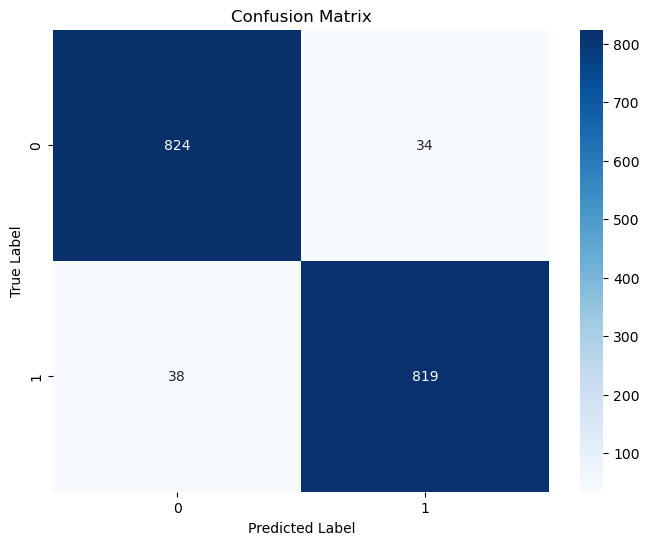

In [9]:
# Evaluate the model on test data
test_loss, test_acc, test_recall = cnn_best_model.evaluate(X_test_cnn, y_test)
print('\nTest Metrics:')
print('-' * 20)
print('Test Accuracy : {:.4f}'.format(test_acc))
print('Test Recall   : {:.4f}'.format(test_recall))

# Predict probabilities and classes
y_pred_proba = cnn_best_model.predict(X_test_cnn).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nDetailed Model Performance Metrics:')
print('-' * 40)
print('Accuracy      : {:.4f}'.format(accuracy))
print('Precision     : {:.4f}'.format(precision))
print('Recall        : {:.4f}'.format(recall))
print('F1 Score      : {:.4f}'.format(f1))

# Print confusion matrix
print('\nConfusion Matrix:')
print('-' * 20)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Print detailed classification report
print('\nClassification Report:')
print('-' * 40)
print(classification_report(y_test, y_pred))

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
# LSTM
from keras_tuner.tuners import GridSearch
from keras.layers import Dense, LSTM, Activation, Dropout
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

# Load Data
df = pd.read_csv('dataset_phishing.csv')

features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags', 'nb_hyphens', 'page_rank', 'avg_word_path', 'ratio_extHyperlinks',
 'longest_words_raw', 'google_index', 'length_hostname', 'longest_word_host', 'domain_registration_length', 'nb_www', 'nb_underscore', 'nb_dots',
 'ratio_extMedia', 'phish_hints', 'domain_in_title', 'web_traffic', 'safe_anchor', 'nb_space', 'shortening_service', 'ip', 'domain_age', 'nb_qm',
 'nb_hyperlinks', 'nb_slash']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape((X.shape[0],1,X.shape[1])) #Reshape features with 1 timestep to fit into RNN 

le = LabelEncoder()
y = le.fit_transform(df["status"])
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

In [11]:
#Define model to fir into GridSearch later
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Choice('units',[128,512,1024,2048]), activation=hp.Choice('activation',['relu','tanh']),input_shape=(1,X.shape[1]))) #4 Different layer sizes
    model.add(Dropout(hp.Float('dropout',0.1,0.5,step=0.1))) #5 different dropout values
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
#Grid search for best hyperparameters
tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20
)
tuner.search(X_train,y_train,epochs=10,validation_data=(X_val,y_val))
lstm_best_model = tuner.get_best_models()[0]
tuner.results_summary()
history = lstm_best_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val,y_val))

y_pred = (lstm_best_model.predict(X_test) > 0.5).astype('int32')

Reloading Tuner from ./untitled_project/tuner0.json
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
units: 512
activation: relu
dropout: 0.2
Score: 0.9562426805496216

Trial 02 summary
Hyperparameters:
units: 128
activation: relu
dropout: 0.30000000000000004
Score: 0.9539089798927307

Trial 10 summary
Hyperparameters:
units: 512
activation: relu
dropout: 0.1
Score: 0.9539089798927307

Trial 13 summary
Hyperparameters:
units: 512
activation: relu
dropout: 0.4
Score: 0.9539089798927307

Trial 12 summary
Hyperparameters:
units: 512
activation: relu
dropout: 0.30000000000000004
Score: 0.9539089798927307

Trial 00 summary
Hyperparameters:
units: 128
activation: relu
dropout: 0.1
Score: 0.9533255696296692

Trial 14 summary
Hyperparameters:
units: 512
activation: relu
dropout: 0.5
Score: 0.9533255696296692

Trial 01 summary
Hyperparameters:
units: 128
activation: relu
dropout: 0.2
Score: 0.

/Users/teckyew/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/teckyew/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9648 - loss: 0.0962 - val_accuracy: 0.9545 - val_loss: 0.1313
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9650 - loss: 0.0927 - val_accuracy: 0.9545 - val_loss: 0.1320
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9661 - loss: 0.0896 - val_accuracy: 0.9551 - val_loss: 0.1343
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9680 - loss: 0.0865 - val_accuracy: 0.9568 - val_loss: 0.1327
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9702 - loss: 0.0845 - val_accuracy: 0.9568 - val_loss: 0.1342
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Start of ensemble model

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

# Load your trained models
mlp_model = mlp_best_model  # Use your trained MLP model
cnn_model = cnn_best_model
lstm_model = lstm_best_model

# Read data
df = pd.read_csv('dataset_phishing.csv')
features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags', 'nb_hyphens', 
            'page_rank', 'avg_word_path', 'ratio_extHyperlinks', 'longest_words_raw', 
            'google_index', 'length_hostname', 'longest_word_host', 
            'domain_registration_length', 'nb_www', 'nb_underscore', 
            'nb_dots', 'ratio_extMedia', 'phish_hints', 
            'domain_in_title', 'web_traffic', 'safe_anchor', 
            'nb_space', 'shortening_service', 'ip', 'domain_age', 
            'nb_qm', 'nb_hyperlinks', 'nb_slash']

X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df["status"])

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for CNN and LSTM
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # (samples, features, 1)
X_val_cnn = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # (samples, features, 1)

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))  # For LSTM
X_val_lstm = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))  
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))  # For LSTM

# Get predictions from each model
mlp_predictions_train = mlp_model.predict(X_train)
mlp_predictions_val = mlp_model.predict(X_val)
mlp_predictions_test = mlp_model.predict(X_test)

cnn_predictions_train = cnn_model.predict(X_train_cnn)
cnn_predictions_val = cnn_model.predict(X_val_cnn)
cnn_predictions_test = cnn_model.predict(X_test_cnn)

lstm_predictions_train = lstm_model.predict(X_train_lstm)
lstm_predictions_val = lstm_model.predict(X_val_lstm)
lstm_predictions_test = lstm_model.predict(X_test_lstm)

# Stack predictions into a new feature set for the final estimator
X_train_stacked = np.column_stack((mlp_predictions_train, cnn_predictions_train, lstm_predictions_train))
X_val_stacked = np.column_stack((mlp_predictions_val, cnn_predictions_val, lstm_predictions_val))
X_test_stacked = np.column_stack((mlp_predictions_test, cnn_predictions_test, lstm_predictions_test))

# Train a final estimator using the stacked predictions
final_estimator = LogisticRegression()

# Define hyperparameters for Grid Search
param_grid = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],  # Only 'l2' for 'lbfgs'
        'solver': ['lbfgs'],
        'max_iter': [100, 200, 300],
        'tol': [1e-4, 1e-5],
        'fit_intercept': [True, False],
        'class_weight': [None, 'balanced']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],  # 'l1' and 'l2' for 'liblinear'
        'solver': ['liblinear'],
        'max_iter': [100, 200, 300],
        'tol': [1e-4, 1e-5],
        'fit_intercept': [True, False],
        'class_weight': [None, 'balanced']
    }
]

# Initialize Grid Search
grid_search = GridSearchCV(estimator=final_estimator, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train_stacked, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters: ", best_params)

# Make predictions on the validation and test sets with the best model
stacked_predictions_val_best = best_estimator.predict(X_val_stacked)
stacked_predictions_test_best = best_estimator.predict(X_test_stacked)

# Calculate performance metrics on the validation set
accuracy_val = accuracy_score(y_val, stacked_predictions_val_best)
precision_val = precision_score(y_val, stacked_predictions_val_best, average='weighted')
recall_val = recall_score(y_val, stacked_predictions_val_best, average='weighted')
f1_val = f1_score(y_val, stacked_predictions_val_best, average='weighted')
stacked_probabilities_val_best = best_estimator.predict_proba(X_val_stacked)
auc_val = roc_auc_score(y_val, stacked_probabilities_val_best[:, 1])

# Calculate performance metrics on the test set
accuracy_test = accuracy_score(y_test, stacked_predictions_test_best)
precision_test = precision_score(y_test, stacked_predictions_test_best, average='weighted')
recall_test = recall_score(y_test, stacked_predictions_test_best, average='weighted')
f1_test = f1_score(y_test, stacked_predictions_test_best, average='weighted')
stacked_probabilities_test_best = best_estimator.predict_proba(X_test_stacked)
auc_test = roc_auc_score(y_test, stacked_probabilities_test_best[:, 1])

# Print performance metrics
print("\nPerformance Metrics for Best Stacked Model on Validation Set:")
print(f"Accuracy       : {accuracy_val:.4f}")
print(f"Precision      : {precision_val:.4f}")
print(f"Recall         : {recall_val:.4f}")
print(f"F1 Score       : {f1_val:.4f}")
print(f"AUC            : {auc_val:.4f}")

print("\nPerformance Metrics for Best Stacked Model on Test Set:")
print(f"Accuracy       : {accuracy_test:.4f}")
print(f"Precision      : {precision_test:.4f}")
print(f"Recall         : {recall_test:.4f}")
print(f"F1 Score       : {f1_test:.4f}")
print(f"AUC            : {auc_test:.4f}")


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END model__dense_units=128, model__dropout_rate_1=0.3, model__dropout_rate_2=0.2, model__filters_1=32, model__filters_2=64, model__kernel_size_1=3, model__kernel_size_2=3, model__learning_rate=0.01; total time=   2.5s
[CV] END model__dense_units=128, model__dropout_rate_1=0.3, model__dropout_rate_2=0.2, model__filters_1=64, model__filters_2=32, model__kernel_size_1=2, model__kernel_size_2=3, model__learning_rate=0.01; total time=   2.8s
[CV] END model__dense_units=128, model__dropout_rate_1=0.3, model__dropout_rate_2=0.2, model__filters_1=64, model__filters_2=32, model__kernel_size_1=3, model__kernel_size_2=3, model__learning_rate=0.001; total time=   3.2s
[CV] END model__dense_units=